In [1]:
#importando as bibliotecas

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import ipywidgets as widgets
from IPython.display import display
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


In [2]:
#importando base de titulos do kaggle
catalogo = pd.read_csv('/content/netflix.csv')

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
# trazer a visualização de dados dos dados do catalogo
catalogo.head(2)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."


## Analises Gerais do Dataframe

In [5]:
# descobrir tipos de dados e colunas
# temos valores nulos nas colunas diretor, cast, country,\
#date_added, rating e duration -> definir se precisaremos tratar a info e se vamos usa-las
catalogo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


In [6]:
# descobrir dimensão do dataframe
catalogo.shape

(8807, 12)

In [7]:
#primeira visão geral das estatisticas e como a maior parte das informações são texto,
# deveremos fazer analises segmentadas.
est = catalogo.describe()
est

,release_year
count,8807.000000
mean,2014.180198
std,8.819312
min,1925.000000
25%,2013.000000
50%,2017.000000
75%,2019.000000
max,2021.000000


In [8]:
# quantos filmes e quantas séreies de TV temos?
tipo = catalogo.groupby(['type'])['show_id'].count().reset_index()
tipo


,type,show_id
0,Movie,6131
1,TV Show,2676


Text(0.5, 1.0, 'TV Shows X Movies')

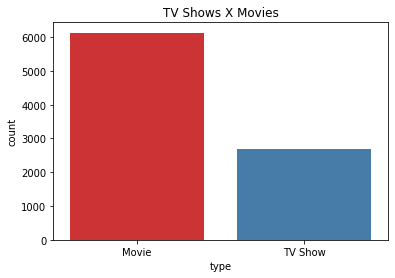

In [9]:
plt.figure()
ax= sns.countplot(x = "type", data = catalogo,palette="Set1")
ax.set_title("TV Shows X Movies")

In [10]:
# qual principal pais?
pais = catalogo.groupby(['country'])['show_id'].count().reset_index()
pais = pais.sort_values(by='show_id', ascending = False)
y = pais.show_id.values
toppais = pais[0:10].reset_index()
pais


,country,show_id
603,United States,2818
251,India,972
506,United Kingdom,419
319,Japan,245
435,South Korea,199
...,...,...
281,"Ireland, Canada, Luxembourg, United States, Un...",1
282,"Ireland, Canada, United Kingdom, United States",1
283,"Ireland, Canada, United States, United Kingdom",1
284,"Ireland, France, Iceland, United States, Mexic...",1


Text(0.5, 1.0, 'Distribuição Paises')

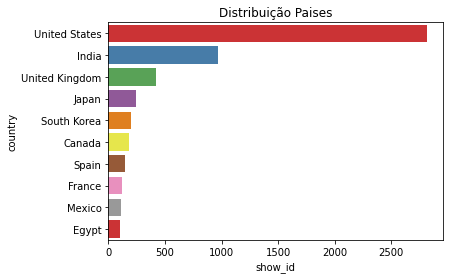

In [11]:
#grafico para visualizar principais paises

plt.figure()

ax = sns.barplot(data=toppais, x="show_id", y="country",palette="Set1")
ax.set_title("Distribuição Paises")

In [12]:
# Qual é o ano principal de lançamento de filmes e séries?
ano = catalogo.groupby(['release_year'])['show_id'].count().sort_values(ascending = False).reset_index()
ano[0:15]

,release_year,show_id
0,2018,1147
1,2017,1032
2,2019,1030
3,2020,953
4,2016,902
5,2021,592
6,2015,560
7,2014,352
8,2013,288
9,2012,237


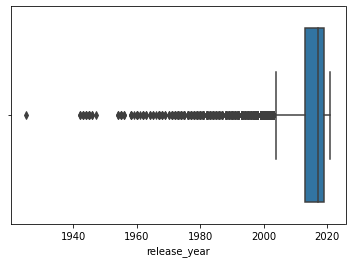

In [13]:
#outlier nos anos referentes a data de lançamento
x = catalogo.release_year.values

sns.boxplot(x=catalogo["release_year"])

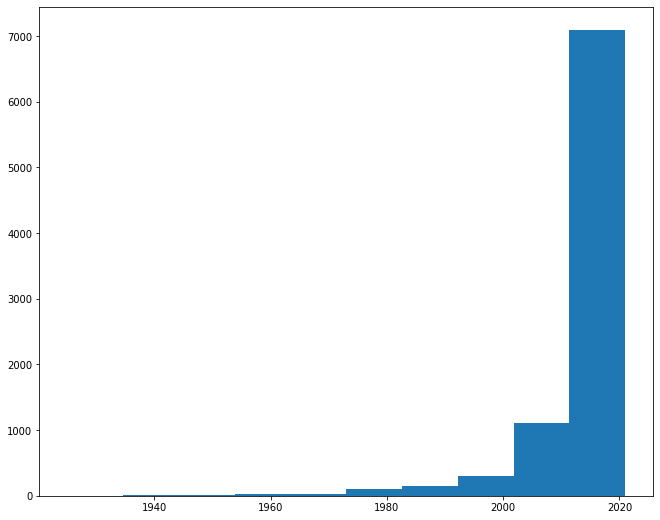

In [14]:
#qual é a frequencia de datas de lançamento?

# os filmes são de data de lançamento mais recente, lançados principalmente apos 2000

y = catalogo.release_year.values
fig,ax = plt.subplots(figsize=(11,9))
ax.hist(y)
plt.show()

In [15]:
catalogo.describe()

# 50% da amostra são filmes lançados a partir de 2017 (aprox, 4400 filmes), com desvio padrão de 9 anos.


,release_year
count,8807.000000
mean,2014.180198
std,8.819312
min,1925.000000
25%,2013.000000
50%,2017.000000
75%,2019.000000
max,2021.000000


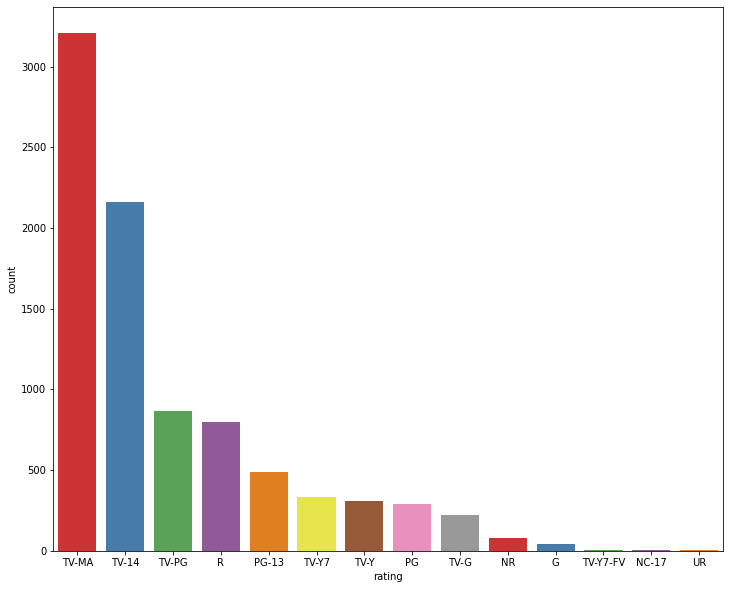

In [16]:
#Qual é a classificação dos filmes?
# Uma importante quantidade de filmes é para uma audiencia mais madura(18+)
# O segundo maior numeros de filmes é para uma audiencia 14+ 
plt.figure(figsize=(12,10))
ax = sns.countplot(x="rating", data=catalogo,palette="Set1",order=catalogo['rating'].value_counts().index[0:14])

In [17]:
#verificando duração
catalogo.loc[catalogo['duration'].isna(), 'duration' ] = 'nao_informado'
catalogo['duration_films'] = catalogo['duration'].str.replace(' min','')
catalogo['duration_films'] = catalogo['duration_films'].str.replace(' Seasons','')
catalogo['duration_films'] = catalogo['duration_films'].str.replace(' Season','')
catalogo['duration_films'] = catalogo['duration_films'].str.replace('nao_informado','0')
catalogo['duration_films'] = catalogo['duration_films'].astype(int)
catalogo[catalogo['type'] == 'Movie'].describe()


,release_year,duration_films
count,6131.000000,6131.000000
mean,2013.121514,99.528462
std,9.678169,28.369284
min,1942.000000,0.000000
25%,2012.000000,87.000000
50%,2016.000000,98.000000
75%,2018.000000,114.000000
max,2021.000000,312.000000


A mediana dos filmes está em 98 min, enquanto a média está em 99,5 min. Até metade dos filmes tem 98 min e 75% deles tem 114 min, o que significa que a maior parte dos filmes do catalogo tem menos de 2 horas de duração.


In [18]:

series = catalogo[catalogo['type'] == 'TV Show']
series.describe()


,release_year,duration_films
count,2676.000000,2676.000000
mean,2016.605755,1.764948
std,5.740138,1.582752
min,1925.000000,1.000000
25%,2016.000000,1.000000
50%,2018.000000,1.000000
75%,2020.000000,2.000000
max,2021.000000,17.000000


A séries em sua maior parte tem 1 temporada, sendo o minímo 1 temporada e o máximo 17. Isso mostra que há uma diferença importante entre a quantidade de temporadas já que o desvio padrão é 1,58, ou seja, 3 desvios padrões são cerca de 6,74 temporadas, mostrando que há outliers na amostra quando a questão são quantidades de temporadas.

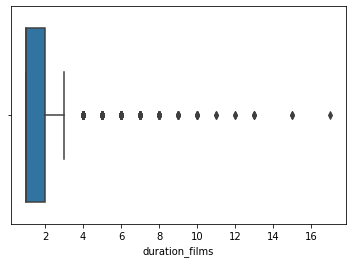

In [19]:
# gráficos mostrando os outlier e concentração de séries de 1 a 2 temporadas.
x = series.duration.values

sns.boxplot(x=series["duration_films"])

## Limpeza de Dados

In [20]:
temp = catalogo.isnull().sum()
uniq = pd.DataFrame({'Colunas': temp.index, 'Vazios': temp.values})
uniq

,Colunas,Vazios
0,show_id,0
1,type,0
2,title,0
3,director,2634
4,cast,825
5,country,831
6,date_added,10
7,release_year,0
8,rating,4
9,duration,0


In [21]:
#retirar a coluna 'director' pois 1/4 do catalogo está com ausencia dessa informação
catalogo = catalogo[['show_id', 'type', 'title', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description']]

In [22]:
# limpando os vazios
# nos campos abaixo a decisão de manter a coluna veio por causa da % da amostra em branco.
catalogo.loc[catalogo['cast'].isna(), 'cast' ] = 'nao_informado'
catalogo.loc[catalogo['country'].isna(), 'country' ] = 'nao_informado'
catalogo.loc[catalogo['rating'].isna(), 'rating' ] = 'nao_informado'
catalogo.loc[catalogo['date_added'].isna(), 'date_added' ] = 'nao_informado'



/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [23]:
#ajuste das colunas de texto e limpeza  dos campos para simplificar ação do algoritmo
catalogo['listed_in'] = catalogo['listed_in'].str.split(',').str[0]
catalogo['cast'] = catalogo['cast'].str.split(',').str[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [24]:
#ajuste dos campos de paises para selecionar somente o primeiro
catalogo['country'] = catalogo['country'].str.split(',').str[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [25]:
catalogo.columns

Index(['show_id', 'type', 'title', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description'],
      dtype='object')

In [26]:
#ajustando colunas para que somente selecionarmos as que iremos usar na recomendação
catalogo[['show_id', 'type', 'title', 'cast', 'country', 
       'release_year', 'rating', 'duration', 'listed_in']]

,show_id,type,title,cast,country,release_year,rating,duration,listed_in
0,s1,Movie,Dick Johnson Is Dead,nao_informado,United States,2020,PG-13,90 min,Documentaries
1,s2,TV Show,Blood & Water,Ama Qamata,South Africa,2021,TV-MA,2 Seasons,International TV Shows
2,s3,TV Show,Ganglands,Sami Bouajila,nao_informado,2021,TV-MA,1 Season,Crime TV Shows
3,s4,TV Show,Jailbirds New Orleans,nao_informado,nao_informado,2021,TV-MA,1 Season,Docuseries
4,s5,TV Show,Kota Factory,Mayur More,India,2021,TV-MA,2 Seasons,International TV Shows
...,...,...,...,...,...,...,...,...,...
8802,s8803,Movie,Zodiac,Mark Ruffalo,United States,2007,R,158 min,Cult Movies
8803,s8804,TV Show,Zombie Dumb,nao_informado,nao_informado,2018,TV-Y7,2 Seasons,Kids' TV
8804,s8805,Movie,Zombieland,Jesse Eisenberg,United States,2009,R,88 min,Comedies
8805,s8806,Movie,Zoom,Tim Allen,United States,2006,PG,88 min,Children & Family Movies


In [27]:
#tratando os campos e criando uma função de titulo limpo
def limpeza_titulo(titulo):
  return re.sub('[^a-zA-Z0-9 ]','',titulo)


## Criando o Algoritmo de Recomendação no formato Contend Based Filtering


In [28]:
# Criando uma estrutura de unificação dos textos das colunas do dataframe para uso do algoritmo.
catalogo['titulo_limpo'] = catalogo['title'].apply(limpeza_titulo)
catalogo['release_year'] = catalogo['release_year'].astype(str)

catalogo['titulo_limpo'] = catalogo['title'].apply(limpeza_titulo) + ' '+ catalogo['country'] + ' ' + catalogo['type'] + ' '+catalogo['rating'] + " " + catalogo['cast'] + " " + catalogo['release_year']

In [29]:
#vetorizando as informaçoes de texto para analise do algoritmo

vectorizer = TfidfVectorizer(ngram_range=(1,3))

tfidf = vectorizer.fit_transform(catalogo['titulo_limpo'])

In [30]:
#criando uma função de busca de similaridade usando a  Similaridade Cos e pegar a lista de títulos mais semilares baseado nos valores do campo da coluna limpeza de titulo

def busca(titulo):
 
  titulo = limpeza_titulo(titulo)
  query_vec = vectorizer.transform([titulo])
  similaridade = cosine_similarity(query_vec,tfidf).flatten()
  indices = np.argpartition(similaridade,-5)[-5:]
  resultado = catalogo.iloc[indices][::-1]
  return resultado

In [31]:
#Criando uma tela  para usuário digitar o filme e ter recomendações de outros

movie_input = widgets.Text(
    value = 'Zodiac',
    description = 'Titulo do Filme:',
    disabled = False
)

lista_filmes= widgets.Output()

def digitacao(data):
  with lista_filmes:
    lista_filmes.clear_output()
    titulo = data["new"]
    if len(titulo)>4:
      display(busca(titulo))



In [32]:
#criação do modulo de input do usuário
movie_input.observe(digitacao, names = 'value')

display(movie_input, lista_filmes)

Text(value='Zodiac', description='Titulo do Filme:')

Output()